# Background creation and parameter exploration

## Explored
- Creation of a flat background/seq
- Influencial parameters in creating a flat background/seq

## Goal
- Obtain a standard set of parameters for creating a flat seq.

In [1]:
# Importing libraries

from basenji import dataset, seqnn, dna_io,stream
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import akita_utils 
import tensorflow as tf
import pysam
import h5py

# Getting genomic data

In [2]:
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile(genome_fasta)

# Loading akita model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
print(tf.__version__)

head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-07-21 07:55:55.736593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [4]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


In [5]:
# visualizing the gc content distribution

# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,5))

# Generating a sample for down stream analysis

In [6]:
super_set = []
error = 0.0001

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,6)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            super_set += [i]
            break

super_set = list(set(super_set)); print(f'Whole distribution: {super_set}')
sample_set = super_set; print(f'Sampled datapoints: {sample_set}')

Whole distribution: [1216, 1286, 140, 111, 597, 600]
Sampled datapoints: [1216, 1286, 140, 111, 597, 600]


# Making predictions for the sampled data

In [7]:
predictions=[]

for ind in set(sample_set):
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)
    predictions.append(seq_1hot)
    
predictions = np.array(predictions)
predictions = seqnn_model.predict(predictions, batch_size=6)

2022-07-21 07:56:57.617197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 07:56:57.617579: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2595380000 Hz


# Creating flat backroung seqs from sampled data

In [8]:
# Paramaters for all analysis downstream
max_iters = 10
batch_size = 5
shuffle_k = 8 
ctcf_thresh = 8 
scores_thresh = 5500 
scores_pixelwise_thresh = .05
new_dataframe = df.iloc[[ind for ind in set(sample_set)]]
# ---------------------------------------------------------------

# For comparison further down
shuffle_set = [2,4,8] # shuffling basepairs to sample for comparison
scores_thresh_set = [5000,5500,6000] # ctcf thresholds to sample for comparison

In [9]:
flat_seqs = akita_utils.create_flat_seqs(seqnn_model=seqnn_model, 
                                        genome_fasta=genome_fasta, 
                                        seq_length=seq_length, 
                                        dataframe=new_dataframe, 
                                        max_iters = max_iters, 
                                        batch_size = batch_size, 
                                        shuffle_k = shuffle_k, 
                                        ctcf_thresh = ctcf_thresh, 
                                        scores_thresh = scores_thresh, 
                                        scores_pixelwise_thresh = scores_pixelwise_thresh )

ind 0 , iter  0 , for chr3 71278592 72589312
success: best seq, thresh 5936.0  pixelwise 0.04382
max iters exceeded
ind 1 , iter  0 , for chr3 8570880 9881600
trying: best seq, thresh 9544.0  pixelwise 0.06976
ind 1 , iter  1 , for chr3 8570880 9881600
trying: best seq, thresh 9470.0  pixelwise 0.0631
ind 1 , iter  2 , for chr3 8570880 9881600
trying: best seq, thresh 7950.0  pixelwise 0.0702
ind 1 , iter  3 , for chr3 8570880 9881600
trying: best seq, thresh 8936.0  pixelwise 0.05783
ind 1 , iter  4 , for chr3 8570880 9881600
trying: best seq, thresh 8936.0  pixelwise 0.0538
ind 1 , iter  5 , for chr3 8570880 9881600
trying: best seq, thresh 9176.0  pixelwise 0.0516
ind 1 , iter  6 , for chr3 8570880 9881600
trying: best seq, thresh 8376.0  pixelwise 0.0809
ind 1 , iter  7 , for chr3 8570880 9881600
trying: best seq, thresh 10390.0  pixelwise 0.06033
ind 1 , iter  8 , for chr3 8570880 9881600
trying: best seq, thresh 9390.0  pixelwise 0.05725
ind 1 , iter  9 , for chr3 8570880 9881600

# Visualizing the created flat seqs' contact maps

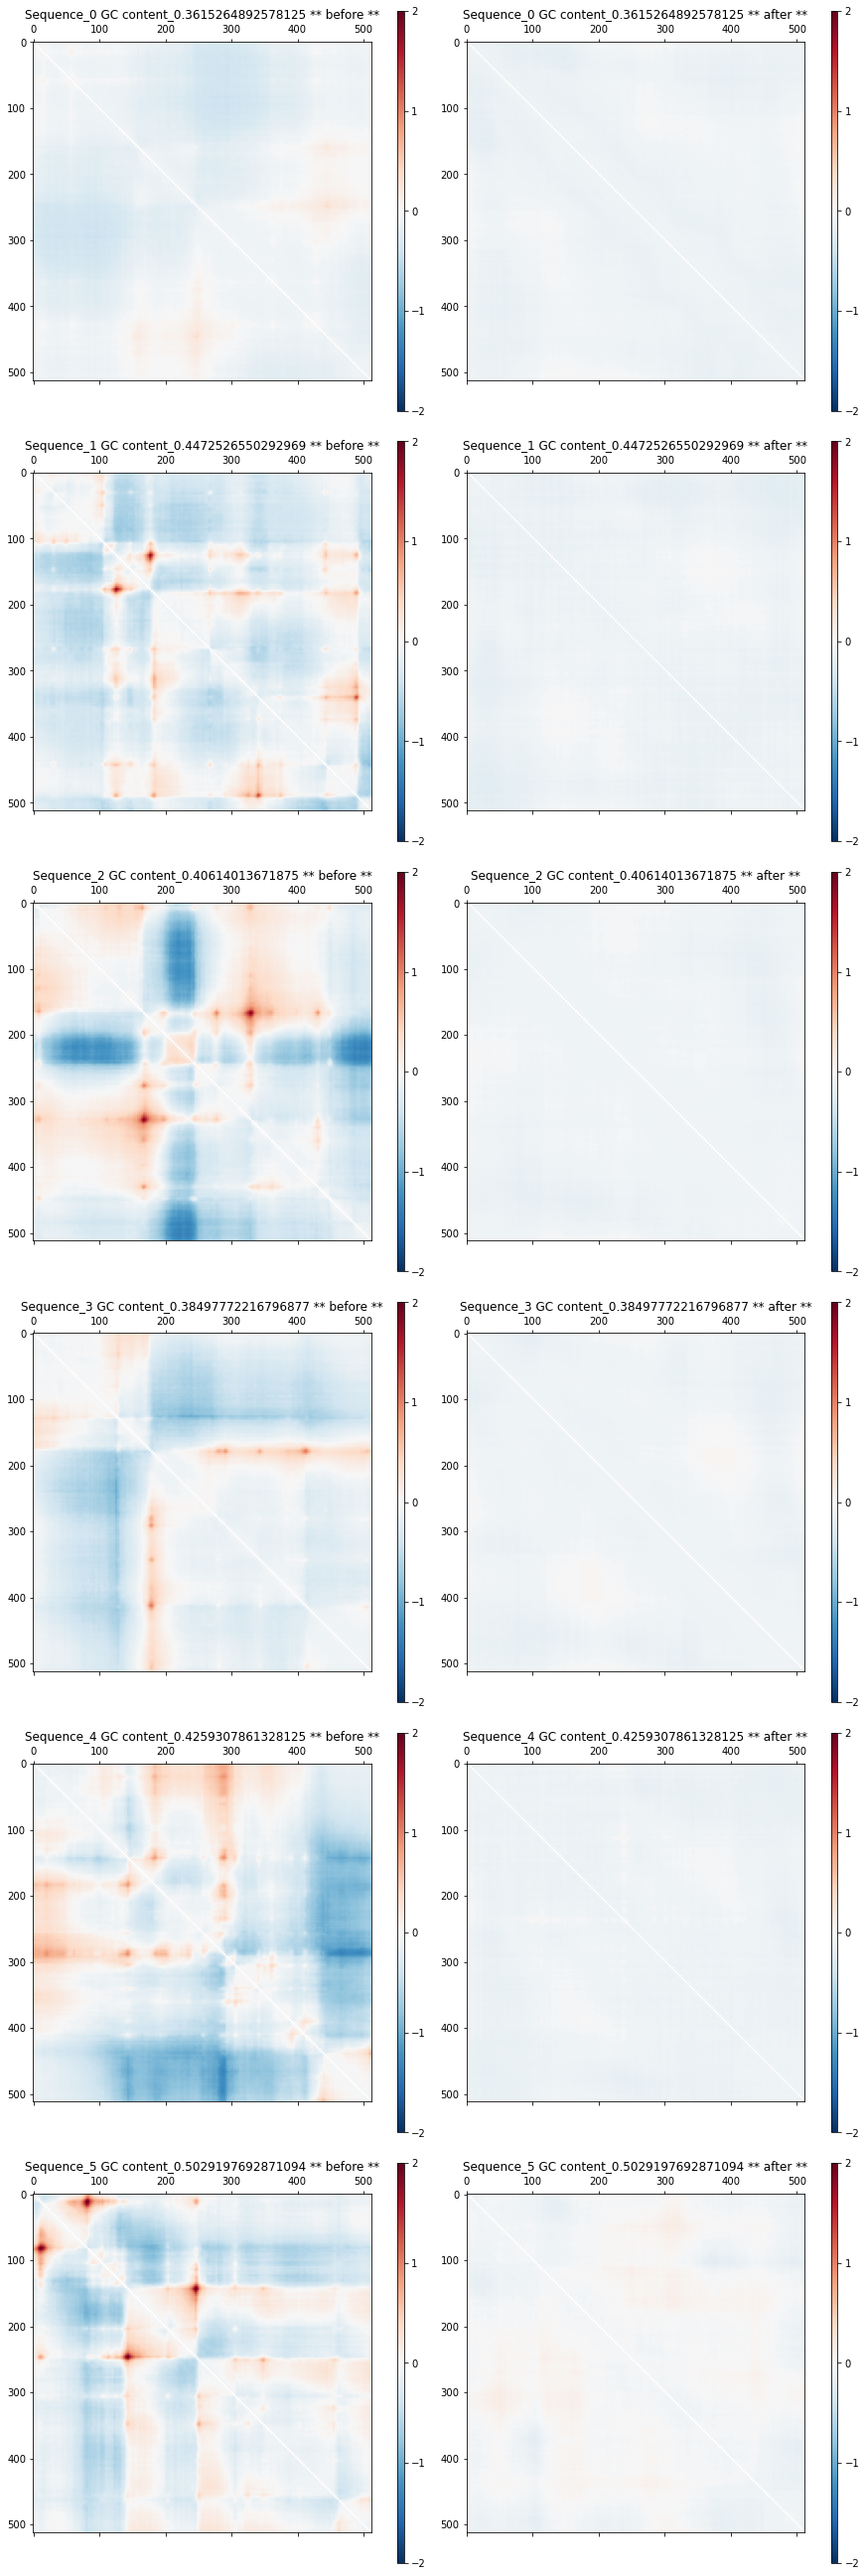

In [10]:
fig = plt.figure(figsize=(6* 2 , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=2, nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    
    flat_pred = flat_seqs[i][1]
    gc        = flat_seqs[i][-1]
    back_pred = predictions[i]

    mat = akita_utils.from_upper_triu(back_pred[:,target_ind], target_map_size,hic_diags)
    ax1 = fig.add_subplot(spec[i,0])
    im = ax1.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
    plt.title(f'Sequence_{i} GC content_{gc} ** before **')       
           
    mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
    ax2 = fig.add_subplot(spec[i,1])
    im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
    plt.title(f'Sequence_{i} GC content_{gc} ** after **')       
        
plt.show()

# General distribution of scores

In [11]:
scores_before = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        scores_before[gc,k] = akita_utils.custom_calculate_scores(  seqnn_model=seqnn_model, 
                                                                    genome_fasta=genome_fasta, 
                                                                    seq_length=seq_length, 
                                                                    dataframe=new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh,
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh)
        
# scores_before

1216 2
ind 0 , iter  0 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  1 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  2 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  3 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  4 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  5 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  6 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  7 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  8 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  9 ,k  2 , for chr3 71278592 72589312
max iters exceeded
1216 4
ind 0 , iter  0 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  1 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  2 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  3 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  4 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  5 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  6 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  7 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  8 ,k  4 , for chr3 71278592 7258931

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  1 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  2 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  3 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  4 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  5 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  6 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  7 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  8 ,k  2 , for chr3 8570880 9881600
ind 0 , iter  9 ,k  2 , for chr3 8570880 9881600
max iters exceeded
1286 4
ind 0 , iter  0 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  1 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  2 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  3 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  4 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  5 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  6 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  7 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  8 ,k  4 , for chr3 8570880 9881600
ind 0 , iter  9 ,k  4 , for chr3 8570880 9881600
max iters exceeded
1286 8
ind 0 , iter  0 ,

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  1 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  2 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  3 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  4 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  5 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  6 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  7 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  8 ,k  2 , for chr1 79708160 81018880
ind 0 , iter  9 ,k  2 , for chr1 79708160 81018880
max iters exceeded
140 4
ind 0 , iter  0 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  1 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  2 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  3 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  4 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  5 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  6 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  7 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  8 ,k  4 , for chr1 79708160 81018880
ind 0 , iter  9 ,k  4 , for chr1 79708160 81018880
max it

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  1 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  2 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  3 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  4 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  5 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  6 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  7 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  8 ,k  2 , for chr2 72554496 73865216
ind 0 , iter  9 ,k  2 , for chr2 72554496 73865216
max iters exceeded
597 4
ind 0 , iter  0 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  1 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  2 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  3 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  4 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  5 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  6 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  7 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  8 ,k  4 , for chr2 72554496 73865216
ind 0 , iter  9 ,k  4 , for chr2 72554496 73865216
max it

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  7 ,k  4 , for chr2 27127808 28438528
ind 0 , iter  8 ,k  4 , for chr2 27127808 28438528
ind 0 , iter  9 ,k  4 , for chr2 27127808 28438528
max iters exceeded
600 8
ind 0 , iter  0 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  1 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  2 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  3 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  4 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  5 ,k  8 , for chr2 27127808 28438528


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  6 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  7 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  8 ,k  8 , for chr2 27127808 28438528
ind 0 , iter  9 ,k  8 , for chr2 27127808 28438528
max iters exceeded


# Visualing the scores' distribution for the created flat seqs

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


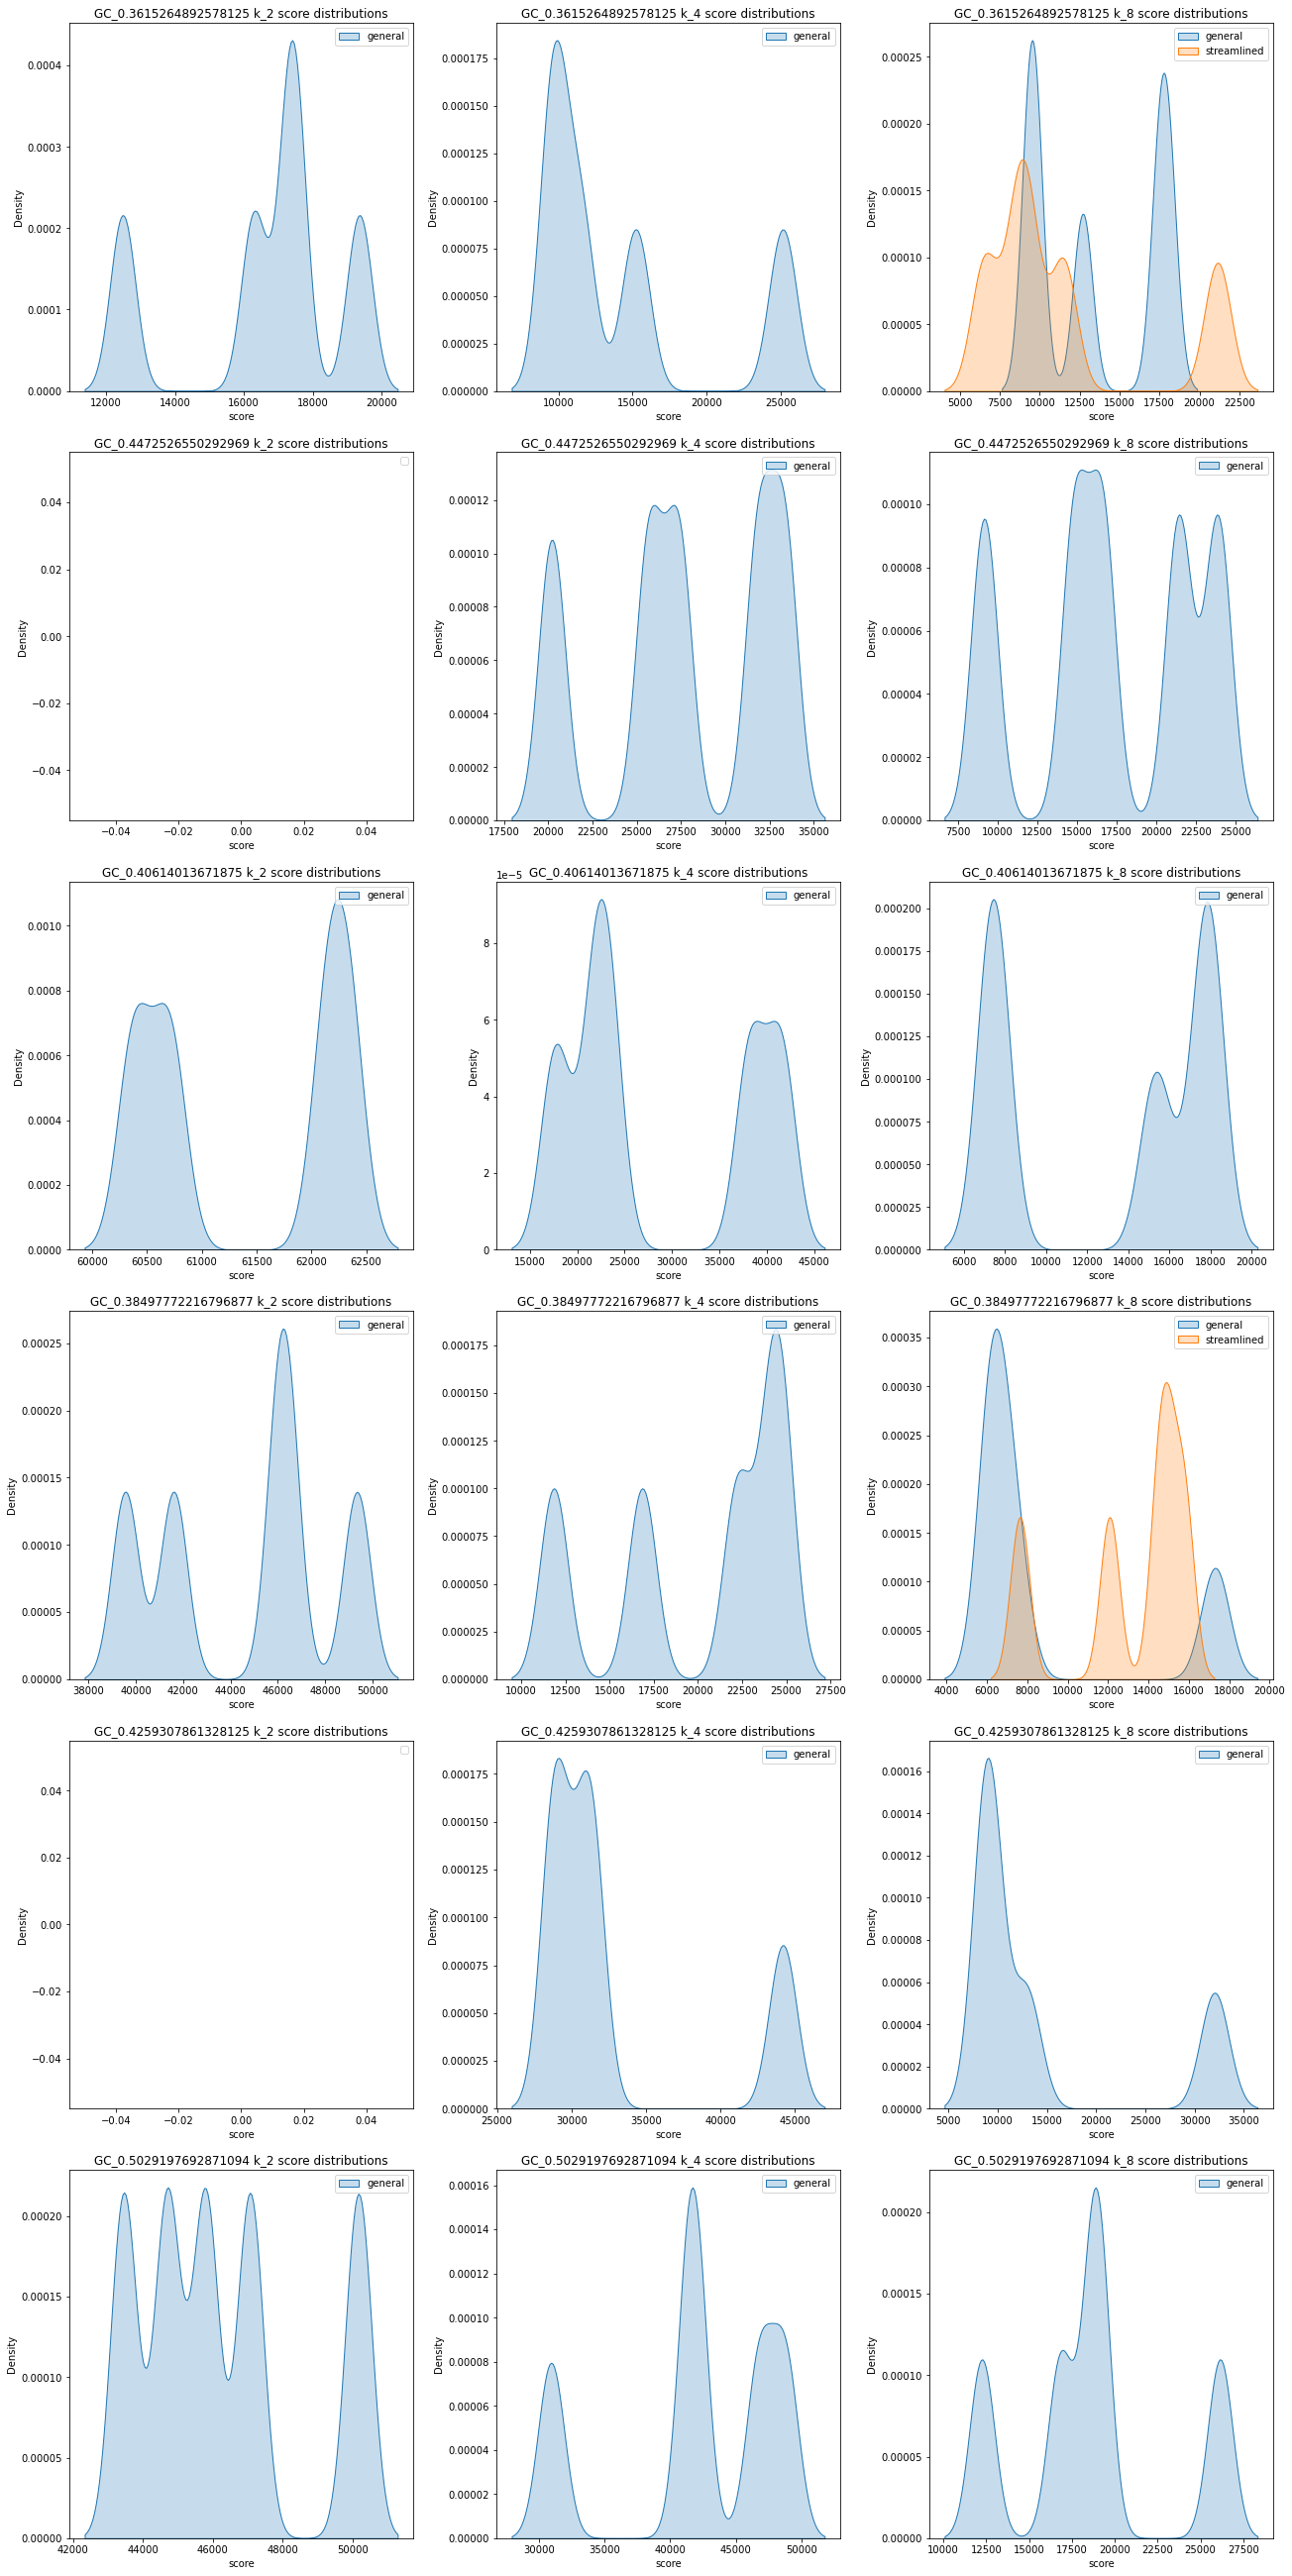

In [14]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        # plt.hist(scores_before[gc,k],10)
        
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.2, fill=True, label="streamlined")
        
        plt.title(f'GC_{gc} k_{k} score distributions')
        plt.legend()

plt.show()
plt.close()

# Some observations

With a threshold of 6000;

As the gc content lowers, scores below threshold are obtained in k=8, some low scores can be obtained in the k=4,2. For really low gc content, more low scores can be obtained for k=4.

This implies k=8 is the best option over a wide range of gc content distribution and thus will be used futher on.

In [15]:
shuffle_set = [8]

# Now we focus on how to maskout some CTCF motifs to lower the structure in our maps


In [16]:
# max_iters=50
# batch_size=6

# scores_storage_random_masking = mutation_search(    seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size,
#                                                     masking=0)

# print('**********************************')

# scores_storage_motif_masking = mutation_search(     seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size,
#                                                     masking=1)

# print('**********************************')

# scores_storage_all_random = mutation_search(        seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size)

In [17]:
# Y_1 = []
# Y_2 = []
# Y_3 = []

# for i in scores_storage_random_masking:
#     for j in scores_storage_random_masking[i]:
#         Y_1 += j.tolist()

# for i in scores_storage_motif_masking:
#     for j in scores_storage_motif_masking[i]:
#         Y_2 += j.tolist()        

# for i in scores_storage_all_random:
#     for j in scores_storage_all_random[i]:
#         Y_3 += j.tolist()

# kde_1 = pd.DataFrame(Y_1, columns=["score"])
# kde_2 = pd.DataFrame(Y_2, columns=["score"])
# kde_3 = pd.DataFrame(Y_3, columns=["score"])
# sns.kdeplot(data=kde_1, x="score", bw_adjust=.2, label='random masking', fill=True)  
# sns.kdeplot(data=kde_2, x="score", bw_adjust=.2, label='motif masking', fill=True)    
# sns.kdeplot(data=kde_3, x="score", bw_adjust=.2, label='all random', fill=True)    
# plt.legend()
# plt.show()

# Some observations

For high gc content, there is no success for k=2,4.  As the gc content lowers, some success can be obtained in the k=4. For really low gc content, more success can be obtained for k=4.

This implies k=8 is the best option over a wide range of gc content distribution.

# Now we try different thresholds to maskout the CTCF motifs
### (strength of motif)

In [18]:
scores_thresh_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for score in scores_thresh_set:
        print(gc,score)
        scores_thresh_after[gc,score] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                            genome_fasta = genome_fasta, 
                                                            seq_length = seq_length, 
                                                            dataframe = new_dataframe, 
                                                            max_iters = max_iters, 
                                                            batch_size = batch_size, 
                                                            shuffle_k = 8, 
                                                            ctcf_thresh = ctcf_thresh, 
                                                            scores_thresh = score, 
                                                            scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                            success_scores = 1,                
                                                            masking = True)

1216 5000
ind 0 , iter  0 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6220.0  pixelwise 0.04465 ***
ind 0 , iter  1 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6180.0  pixelwise 0.03983 ***
ind 0 , iter  2 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6110.0  pixelwise 0.04517 ***
ind 0 , iter  3 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5080.0  pixelwise 0.03796 ***
ind 0 , iter  4 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6024.0  pixelwise 0.0399 ***
ind 0 , iter  5 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5896.0  pixelwise 0.0498 ***
ind 0 , iter  6 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6364.0  pixelwise 0.04413 ***
ind 0 , iter  7 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6330.0  pixelwise 0.04456 ***
ind 0 , iter  8 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5828.0  pixelwise 0.037

# Visualing the scores' distribution for the created seqs

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


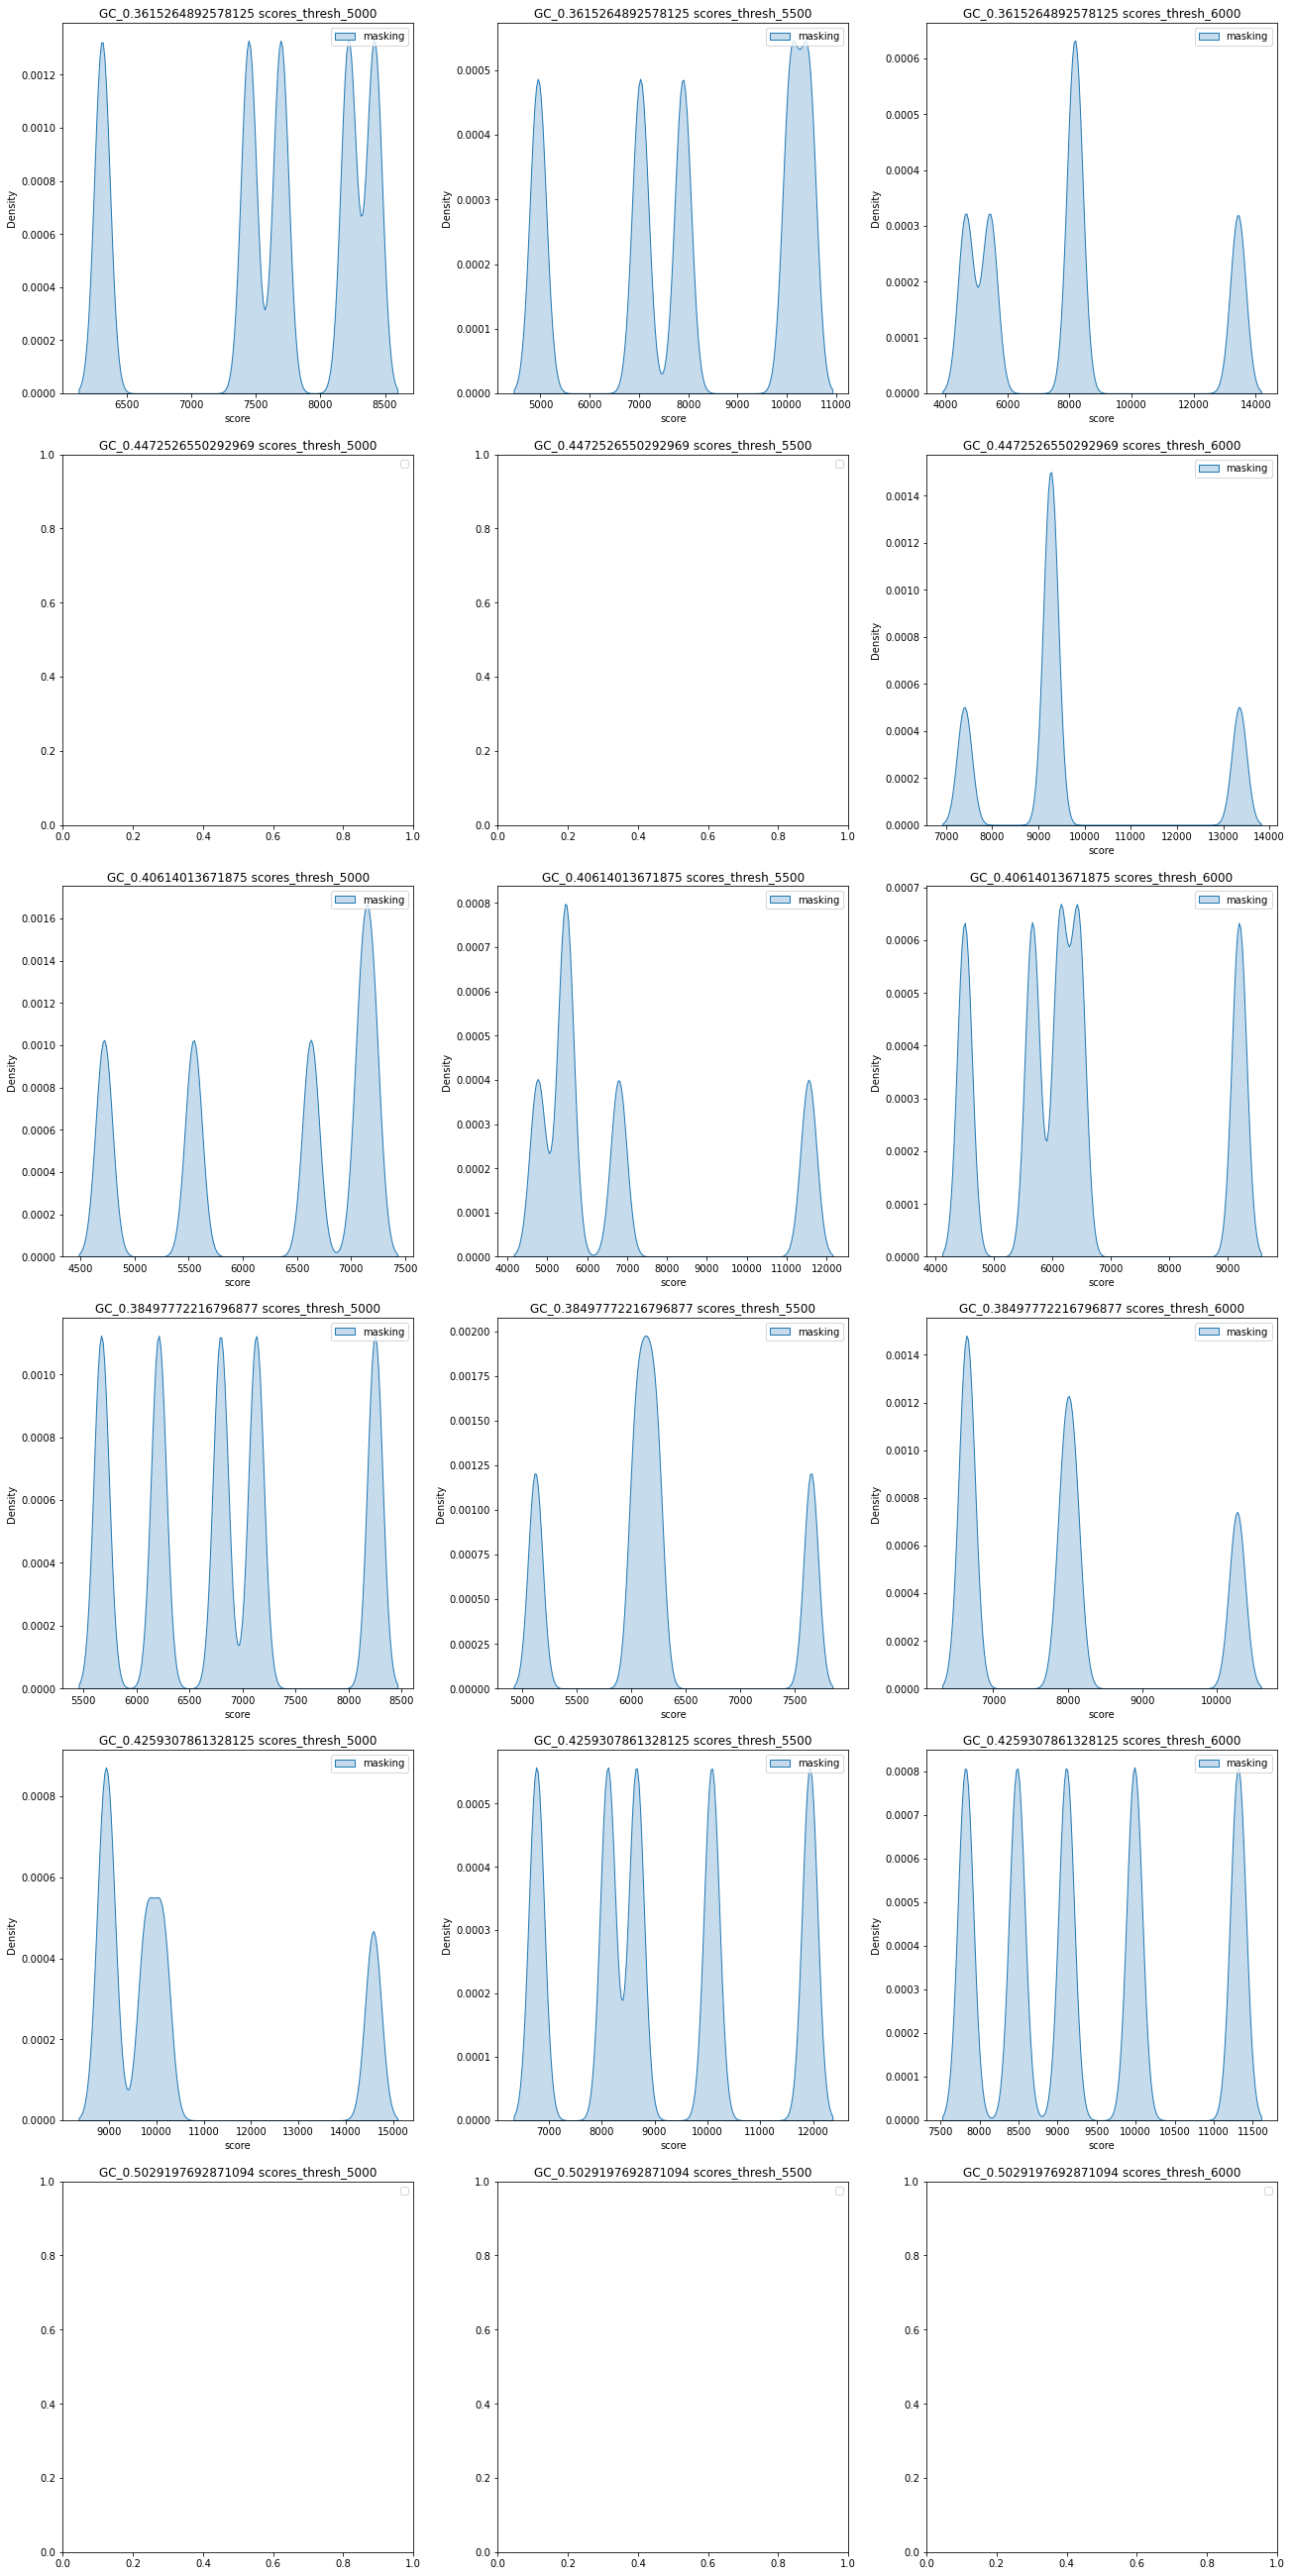

In [19]:
fig1 = plt.figure(figsize=(6* len(scores_thresh_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec1 = fig1.add_gridspec(ncols=len(scores_thresh_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for score in scores_thresh_set:
        ax1 = fig1.add_subplot(spec1[sample_set.index(ind),scores_thresh_set.index(score)])
        
        temp_scores_thresh_after = []
        for i in scores_thresh_after[ind,score]:
            temp_scores_thresh_after =+ i
        
        kde_df_after = pd.DataFrame(temp_scores_thresh_after, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, fill=True)
        ax1.legend()        
        plt.title(f'GC_{gc} scores_thresh_{score}')

plt.show()
plt.close()

# Some observations


For high gc content and low threshold, there is no success.  As the gc content lowers, some success can be obtained in higher thresholds. For really low gc content, more success can be obtained for lower thresholds.

This implies that to create a background seq, you need a reasonably low gc content and threshold.

# Now we focus on effect of masking to basepairs shuffled.  

In [20]:
scores_shuffle_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        scores_shuffle_after[gc,k] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                                    genome_fasta = genome_fasta, 
                                                                    seq_length = seq_length, 
                                                                    dataframe = new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh, 
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                                    success_scores = 1,
                                                                    masking = False)

1216 8
ind 0 , iter  0 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 9470.0  pixelwise 0.0827
ind 0 , iter  1 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 8420.0  pixelwise 0.0673
ind 0 , iter  2 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 6576.0  pixelwise 0.05133
ind 0 , iter  3 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 7508.0  pixelwise 0.05566
ind 0 , iter  4 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 7964.0  pixelwise 0.0749
ind 0 , iter  5 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 5930.0  pixelwise 0.0812
ind 0 , iter  6 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 6908.0  pixelwise 0.05643
ind 0 , iter  7 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 6510.0  pixelwise 0.05923
ind 0 , iter  8 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 8850.0  pixelwise 0.0679
ind 0 , iter  9 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh 14600.0  pixelwise 0.142
ind 0 , iter  7 ,k  8 , for chr2 27127808 28438528
trying: best seq, thresh 10824.0  pixelwise 0.2139
ind 0 , iter  8 ,k  8 , for chr2 27127808 28438528
trying: best seq, thresh 20140.0  pixelwise 0.1857
ind 0 , iter  9 ,k  8 , for chr2 27127808 28438528
trying: best seq, thresh 15940.0  pixelwise 0.1833
max iters exceeded


# Visualizing the resultant score distributions.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


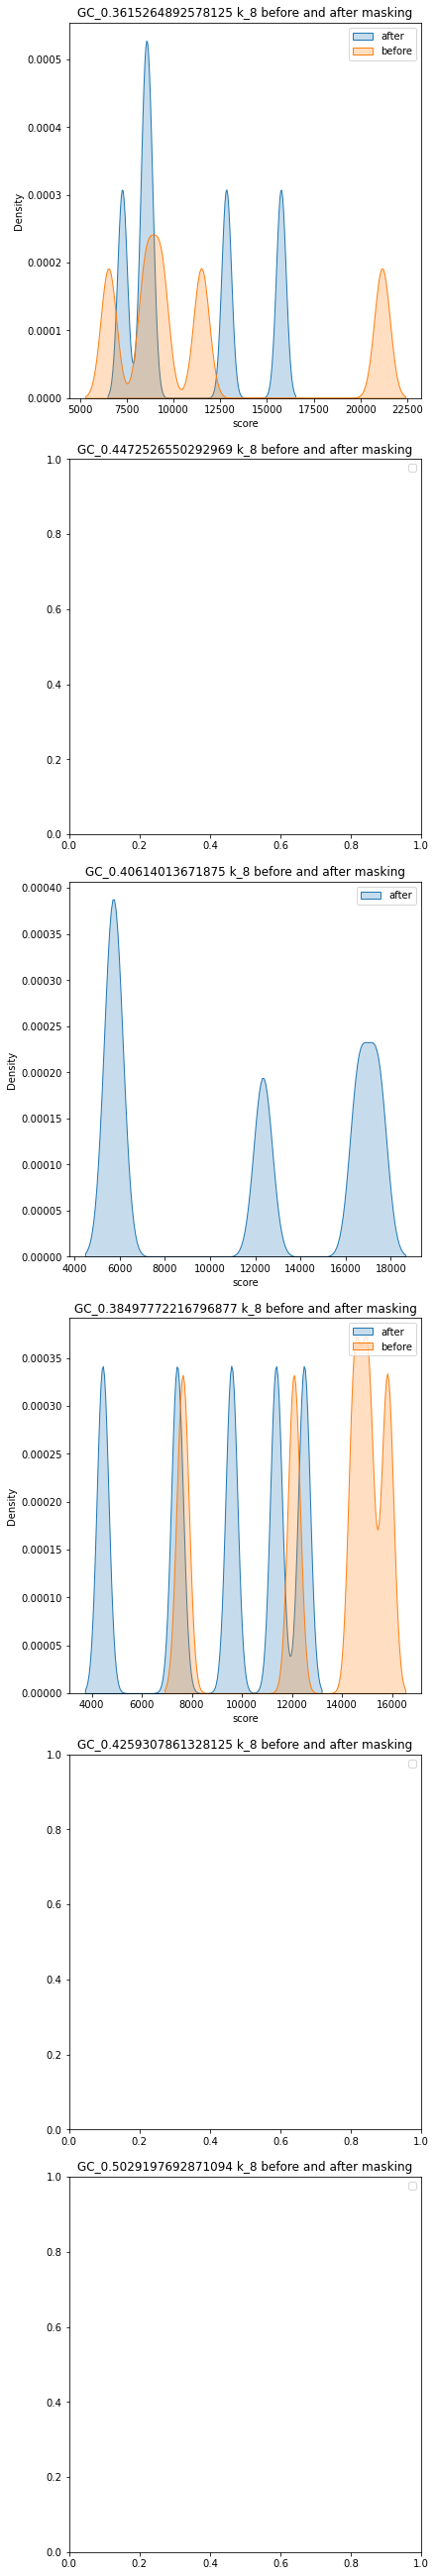

In [21]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        # plt.hist(scores_after[gc,k],5)
        
        temp_scores_shuffle_after = []
        for i in scores_shuffle_after[ind,k]:
            temp_scores_shuffle_after =+ i
            
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_after = pd.DataFrame(temp_scores_shuffle_after, columns=["score"])
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, label='after',fill=True)
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.1, label='before',fill=True)#
        ax1.legend()
        plt.title(f'GC_{gc} k_{k} before and after masking')
plt.show()
plt.close()

# Final observations

The first parameter for focus when desighing a background seq is the gc content of the initial seq.
Seq with lower gc are preffeerd

The second parameter is the shuffling basepairs, k=8 is prefferd

Third is threshold, i have chosen 6000